In [71]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from random import randint
from tkinter import *
import random
import bitstring
import math
import struct
import random

In [76]:
#Method to create a range of floats

def frange(x, y, jump):
    while x < y:
        yield round(x, -int(math.log10(jump)))
        x += jump

#Method to define M1

def M1(x):
    return math.sin(5*math.pi*x)**6

#Method to create a random float between 0 and 1 with -int(math.log10(jump)) decimal points

def create_random_solution(jump):
    return round(random.uniform(0, 1), -int(math.log10(jump)))

#Method to convert a float to a 32-bit binary list

def float_to_binary(num):
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))

#Method to convert a 32-bit binary list to float

def binary_to_float(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

#Method to create the initial poulation

def create_initial_population(population_size, jump):
    initial_population = []
    for i in range(population_size):
        initial_population.append(float_to_binary(create_random_solution(jump)))
    return initial_population

#Method to calculate the cost of a solution

def cost_of_solution(solution):
    return M1(binary_to_float(solution))


#Method to create a dictionary of chromosomes with their finesses

def create_dictionary_with_percentages_of_cumulated_fitness(population, best_solutions, sigma_share):
    fitness_dictionary = dict((str(element),0) for element in population)
    for solution in population:
        is_in_radius = 0
        if not best_solutions:
            fitness_dictionary[str(solution)] = M1(binary_to_float(solution))
        else:
            for b in best_solutions:
                if binary_to_float(b) - sigma_share <= binary_to_float(solution) <= binary_to_float(b) + sigma_share:
                    is_in_radius = 1
            if is_in_radius == 1:
                fitness_dictionary[str(solution)] = 0
            else:
                fitness_dictionary[str(solution)] = M1(binary_to_float(solution))
    sum_of_fitnesses = sum(fitness_dictionary.values())
    for solution in population:
        if sum_of_fitnesses == 0:
            continue
        else:
            fitness_dictionary[str(solution)] = fitness_dictionary[str(solution)] / sum_of_fitnesses
        
    return fitness_dictionary

#Method for random wheel selection

def random_wheel_selection(fitness_dictionary):
    key = random.choice(list(fitness_dictionary))
    return key

#Crossover is currently looking for max solutions

def crossover(solution1, solution2):  
    #Make new var out of the first half of the first solution and the second half of the second solution
    if(solution1 >= solution2):
        newBinSol = solution1[:16] + solution2[16:]
        return newBinSol
    
    else:
        newBinSol = solution2[:16] + solution1[16:]
        return newBinSol
    

def generate_crossover_solutions(population, percentage_crossover, best_solutions, sigma_share):
    fitness_dictionary = create_dictionary_with_percentages_of_cumulated_fitness(population, best_solutions, sigma_share)
    Number_of_crossover_solutions = int(percentage_crossover * len(population))
    crossover_solutions = []
    for i in range(Number_of_crossover_solutions):
        parent_1 = random_wheel_selection(fitness_dictionary)
        parent_2 = random_wheel_selection(fitness_dictionary)
        crossover_solutions.append(crossover(parent_1, parent_2))
    return crossover_solutions

#Method to generate mutated solutions

def generate_mutated_solutions(population, percentage_mutation):
    number_of_mutated_solutions = int(percentage_mutation * len(population))
    mutated_solutions = []
    for i in range(number_of_mutated_solutions):
        parent = random.choice(population)
        index = randint(0, len(parent)-1)
        if parent[index] == 0:
            intermediate = list(parent)
            intermediate[index] = '1'
            parent = ''.join(intermediate)
        else:
            intermediate = list(parent)
            intermediate[index] = '0'
            parent = ''.join(intermediate)
        mutated_solutions.append(parent)
    return mutated_solutions
  
def mutate(solution):
    if(randint(1,100)/100 > mutationRate):
        solutionBin = float_to_bin(solution)
        
        solutionList = list(solutionBin)
        randomIndex = randint(16, 31)
        
        if(solutionList[randomIndex] == "1"):
            solutionList[randomIndex]  == "0"
            
        elif(solutionList[randomIndex] == "0"):
            solutionList[randomIndex]  == "1"
            
        return "".join(solutionList)
        
    else:
        return solution

    
    #Method to calculate the min, max and average costs of a population

def cost_of_population(population):
    min_cost = 9999999999999999999999999
    max_cost = 0
    average_cost = 0
    for solution in population:
        cost = M1(binary_to_float(solution))
        if cost < min_cost:
            min_cost = cost
        if cost > max_cost:
            max_cost = cost
    average_cost = (max_cost + min_cost) / 2
    return min_cost, max_cost, average_cost

#Method to get the best solution in a population

def best_solution_in_population(population):
    best_solution = []
    min_cost = 9999999999999999999999999
    max_cost = 0
    for solution in population:
        cost = M1(binary_to_float(solution))
        if cost > max_cost:
            max_cost = cost
            best_solution = solution
    return best_solution

#Method to select the elit population

def select_elit_population(population, crossover_paths, mutated_paths, population_size, best_solutions, sigma_share):
    grouped_population = population + crossover_paths + mutated_paths
    fitness_dictionary = create_dictionary_with_percentages_of_cumulated_fitness(grouped_population, best_solutions, sigma_share)
    elit_population = sorted(fitness_dictionary, key=fitness_dictionary.get, reverse=True)[:population_size]
    return elit_population

#Method to plot the evolution over time

def plot_evolution_over_time(min_costs_over_time, max_costs_over_time, average_costs_over_time):
    plt.plot(list(range(len(average_costs_over_time))), average_costs_over_time, color='b', label='Average cost')
    plt.plot(list(range(len(min_costs_over_time))), min_costs_over_time, color='g', label='Min cost')
    plt.plot(list(range(len(max_costs_over_time))), max_costs_over_time, color='r', label='Max cost')
    plt.xlabel('Iteration')
    plt.ylabel('Path cost')
    plt.title('M1 Hill climbing vs Fitness')
    plt.legend()
    plt.show()

#Method to apply GA with sequential niching

def GA_with_sequential(population_size, number_iterations, number_solutions, percentage_crossover, percentage_mutation):
    
    sigma_share = 1 / number_solutions
    
    best_solutions = []
    max_solutions = []
    min_solutions = []
    for j in range(number_solutions):
      
        #Initializing and creating initial population
        population = create_initial_population(population_size, 0.001)
        min_costs_over_time = []
        max_costs_over_time = []
        average_costs_over_time = []
        min_cost, max_cost, average_cost = cost_of_population(population)
        min_costs_over_time.append(min_cost)
        max_costs_over_time.append(max_cost)
        average_costs_over_time.append(average_cost)
        
        for i in range(number_iterations):
    
            #Crossover
            crossover_solutions = generate_crossover_solutions(population, percentage_crossover, best_solutions, sigma_share)
      
            #Mutation
            mutated_solutions = generate_mutated_solutions(population, percentage_mutation)
      
            #Elitism
            population = select_elit_population(population, crossover_solutions, mutated_solutions, population_size, best_solutions, sigma_share)
      
            min_cost, max_cost, average_cost = cost_of_population(population)
            min_costs_over_time.append(min_cost)
            max_costs_over_time.append(max_cost)
            average_costs_over_time.append(average_cost)
          
        plot_evolution_over_time(min_costs_over_time, max_costs_over_time, average_costs_over_time)
        best_solution = best_solution_in_population(population)
        best_solutions.append(best_solution)
        print(binary_to_float(best_solution))
        print(M1(binary_to_float(best_solution)))
      
    return best_solutions
    

In [77]:
population_size = 10
number_iterations = 20
number_solutions = 10
percentage_crossover = 0.95
percentage_mutation = 0.1
jump = 0.001

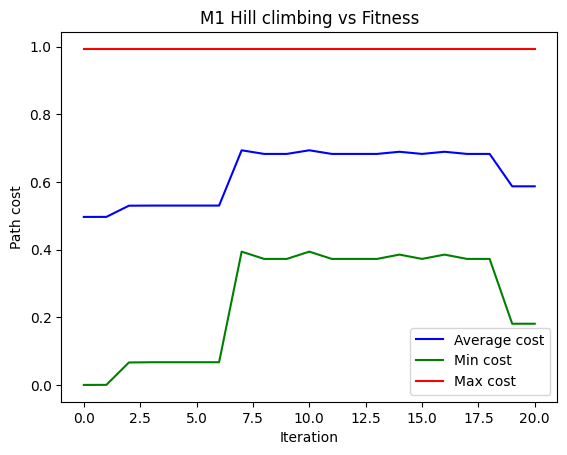

0.10299994051456451
0.9933579707277087


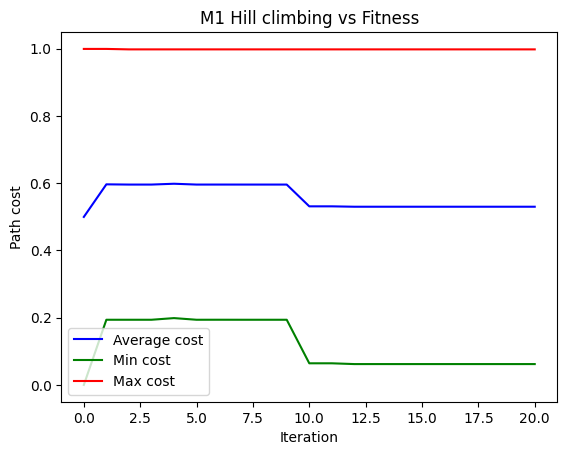

0.7016875147819519
0.9978940437655999


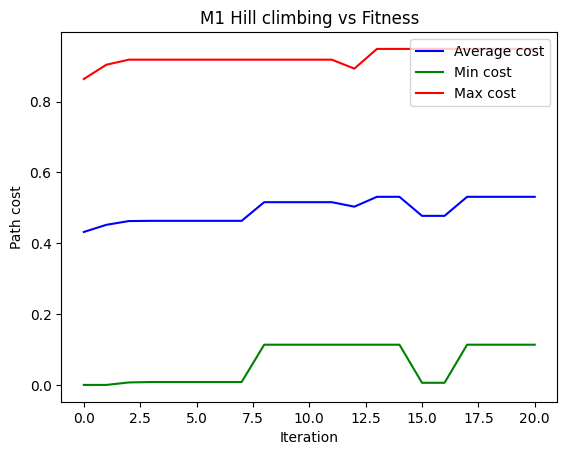

0.9084062576293945
0.948891792184556


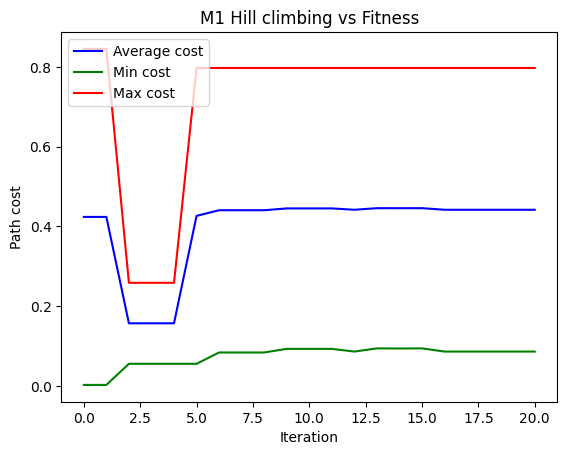

0.3173750042915344
0.7974817364806389


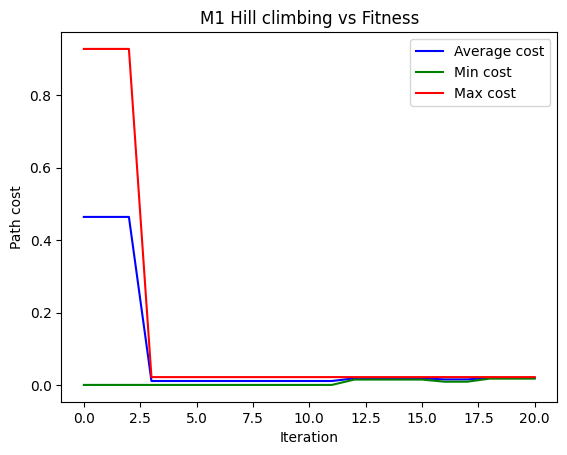

0.4353906214237213
0.021598481203549905


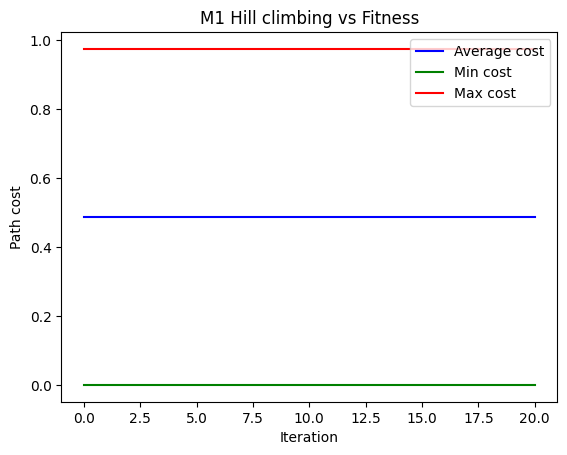

0.8939999938011169
0.9736654337832974


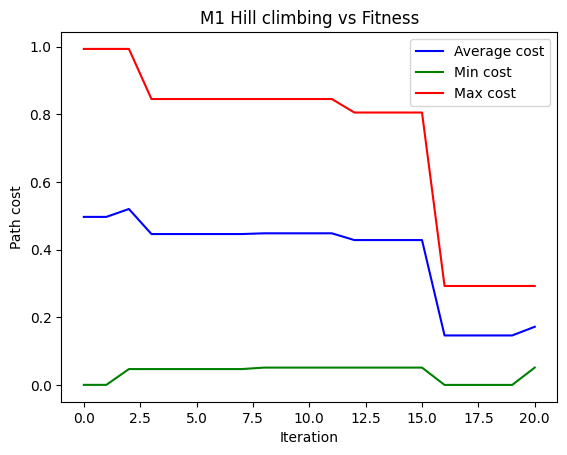

0.5393750071525574
0.2925102932493867


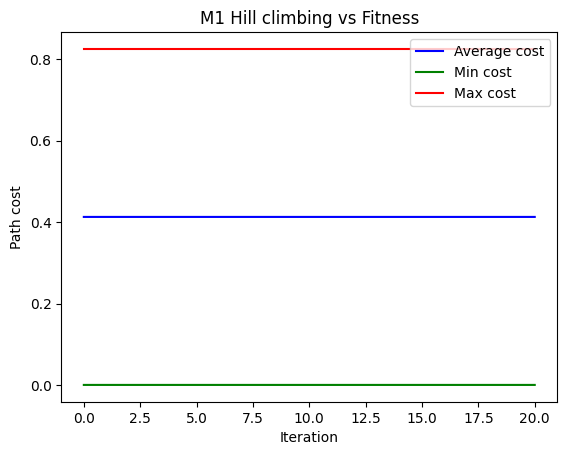

0.2840000092983246
0.825698669852749


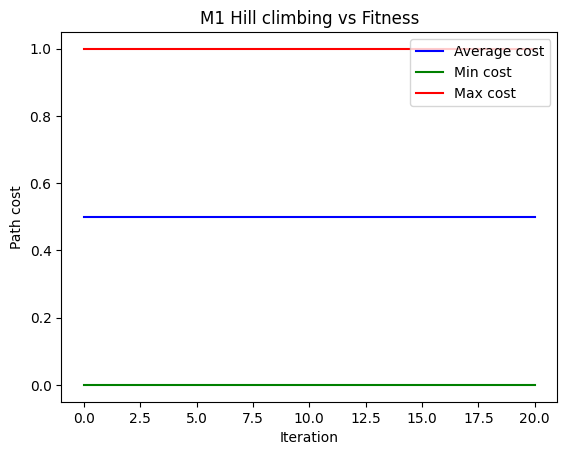

0.8989999890327454
0.9992600069198055


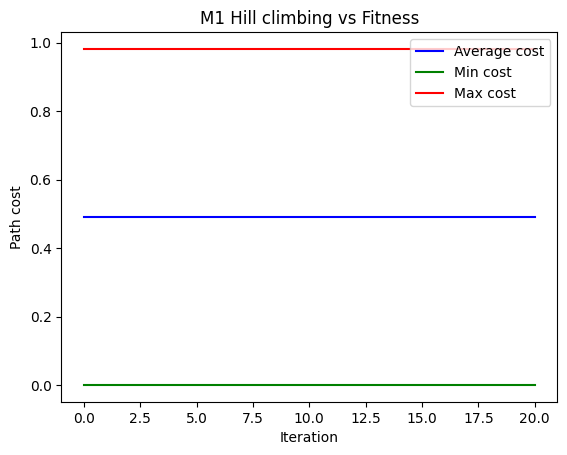

0.0949999988079071
0.9816459516601866


In [78]:
best_solutions = GA_with_sequential(population_size, number_iterations, number_solutions, percentage_crossover, percentage_mutation)

0.9933579707277087
0.9978940437655999
0.948891792184556
0.7974817364806389
0.021598481203549905
0.9736654337832974
0.2925102932493867
0.825698669852749
0.9992600069198055
0.9816459516601866


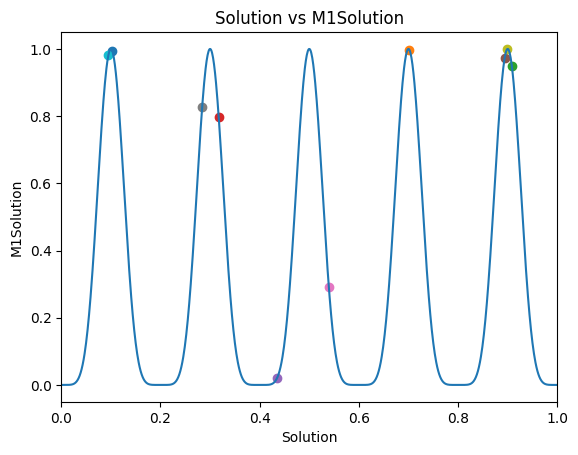

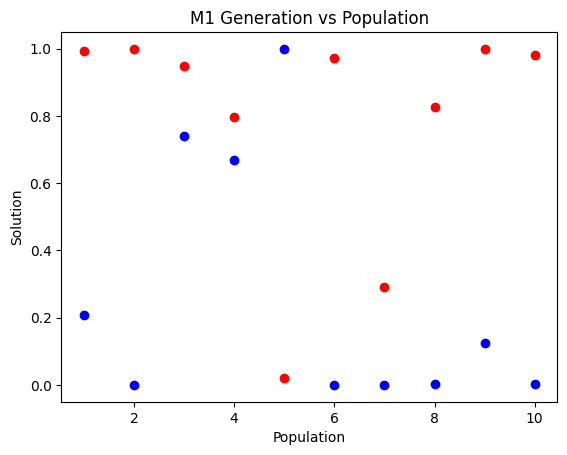

In [79]:
for s in best_solutions:
    print(M1(binary_to_float(s)))
plt.figure()
plt.xlim(0, 1)
plt.plot(list(frange(0, 1, 0.001)), [M1(x) for x in list(frange(0, 1, 0.001))])
for solution in best_solutions:
    plt.scatter(binary_to_float(solution), M1(binary_to_float(solution)))
plt.xlabel('Solution')
plt.ylabel('M1Solution')
plt.title('Solution vs M1Solution')
plt.show()

populationList = [x for x in range(1, population_size+1)]

initialpop = []
for x in population:
    initialpop.append(M1(binary_to_float(x)))
bestsolutions = []
for solution in best_solutions:
    bestsolutions.append(M1(binary_to_float(solution)))

plt.scatter(np.array(populationList), np.array(initialpop), color = "b")
plt.scatter(np.array(populationList), np.array(bestsolutions), color = "r")
plt.title("M1 Generation vs Population")
plt.xlabel("Population")
plt.ylabel("Solution")

plt.show()

In [31]:
for s in best_solutions:
    print(binary_to_float(s))

0.5062109231948853


In [32]:
for s in best_solutions:
    print(M1(binary_to_float(s)))

0.9718052723454093


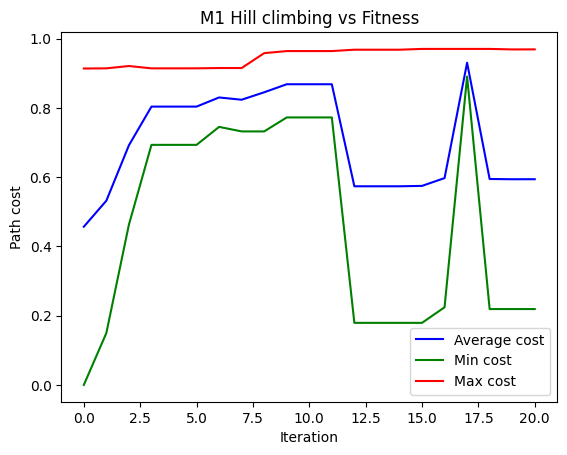

0.9064986705780029
0.9691693038022718


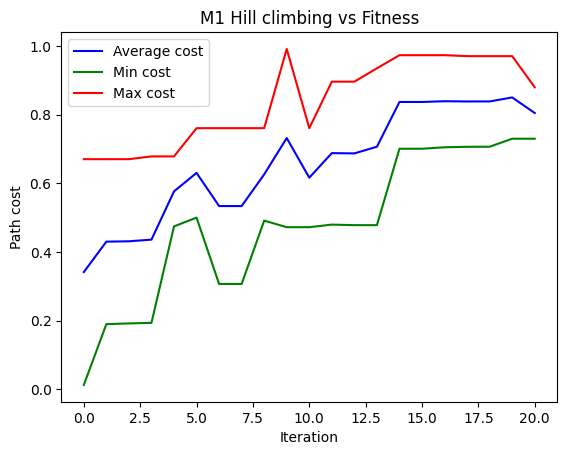

0.08686719089746475
0.8793412841927908


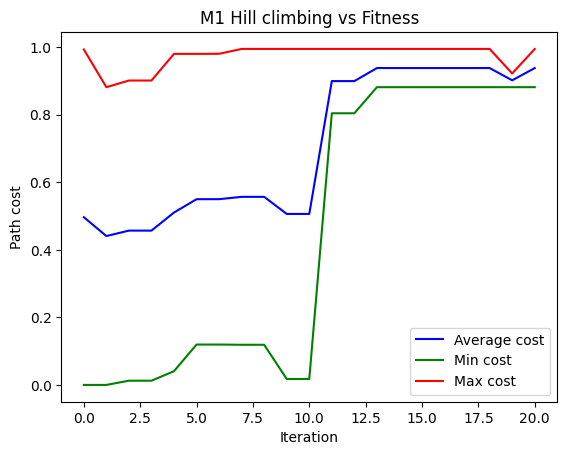

0.697342574596405
0.9947847588703452


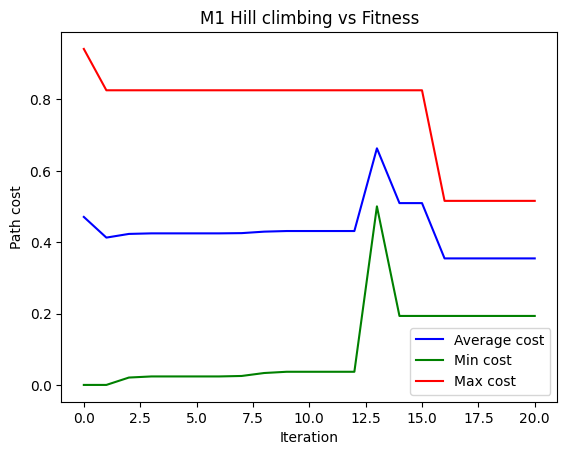

0.470640629529953
0.5157988285590092


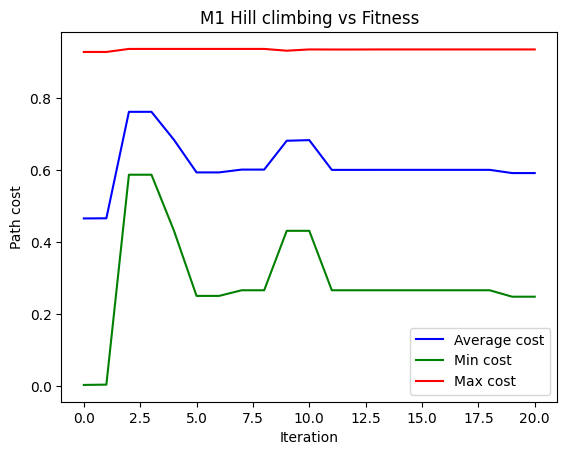

0.29051563143730164
0.9353513914189318


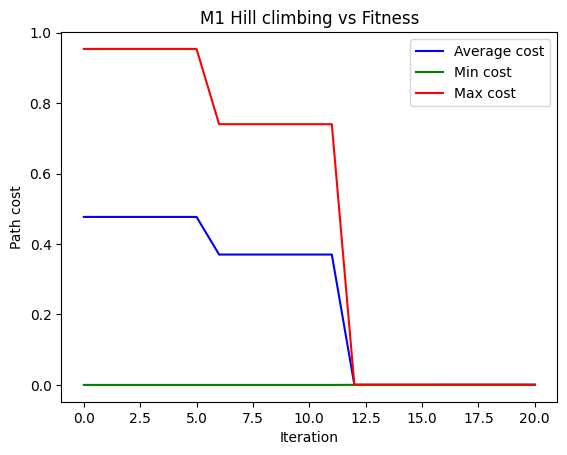

0.5821566581726074
0.0004480940781880501


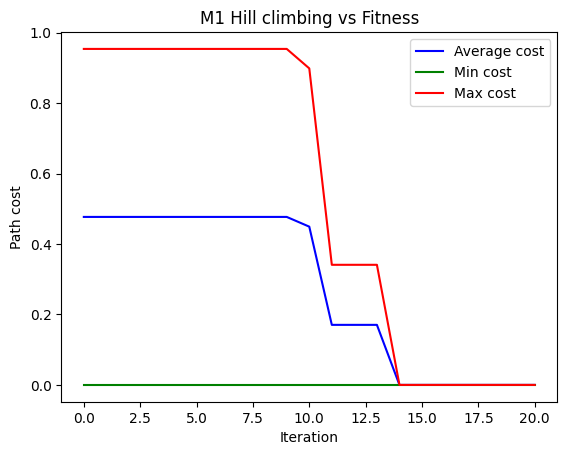

0.8058124780654907
5.744680764975113e-07


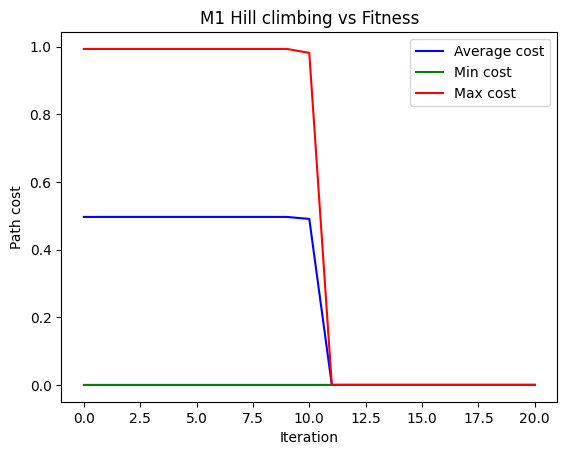

0.18750010430812836
5.51306216133273e-05


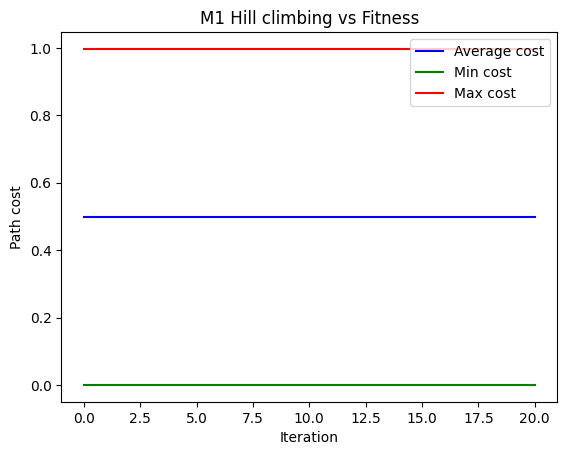

0.49799999594688416
0.9970430000632298


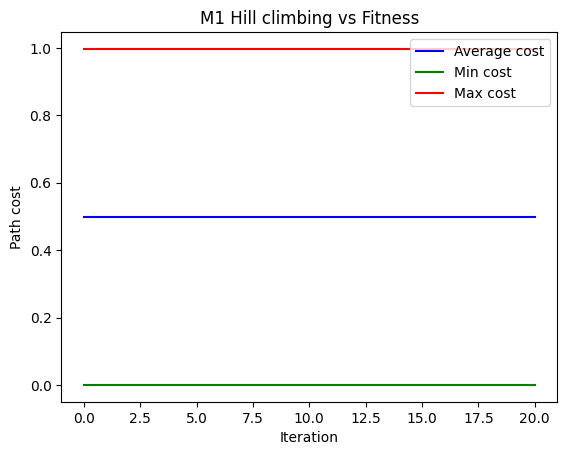

0.49799999594688416
0.9970430000632298


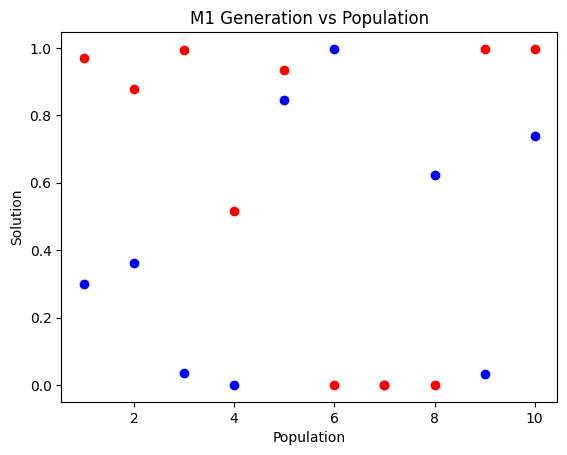

0.9691693038022718
0.8793412841927908
0.9947847588703452
0.5157988285590092
0.9353513914189318
0.0004480940781880501
5.744680764975113e-07
5.51306216133273e-05
0.9970430000632298
0.9970430000632298


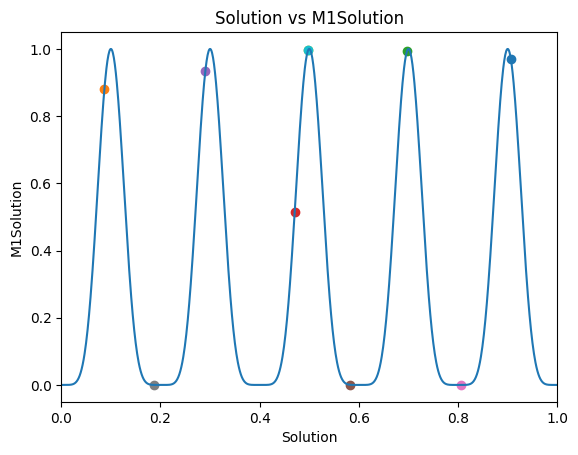

In [105]:
%run GeneticAlgorithmM1Sequential.py

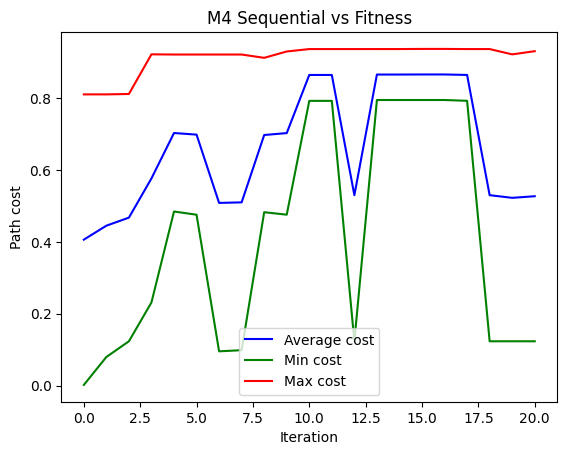

0.2510576844215393
0.930708385724347


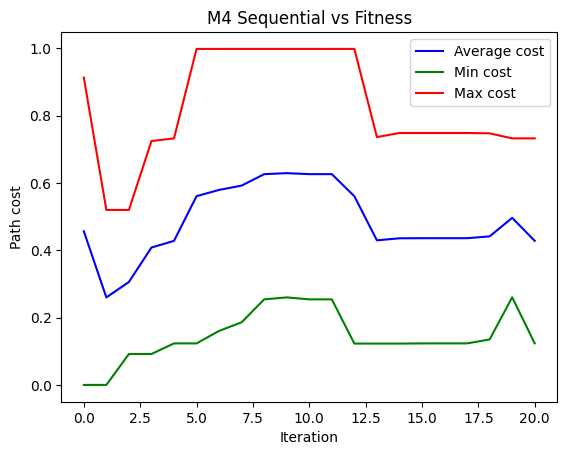

0.09439647197723389
0.7328810668475813


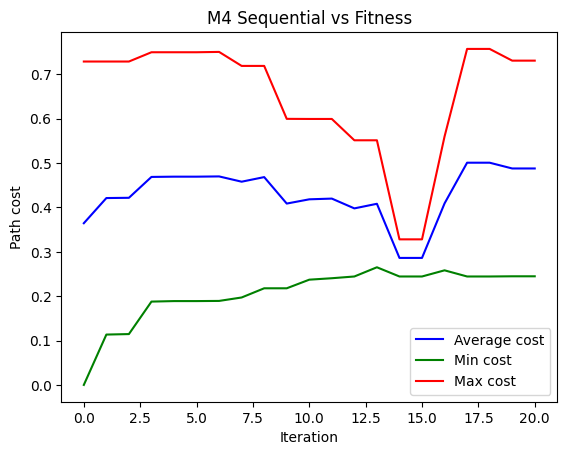

0.45876529812812805
0.7307452717066413


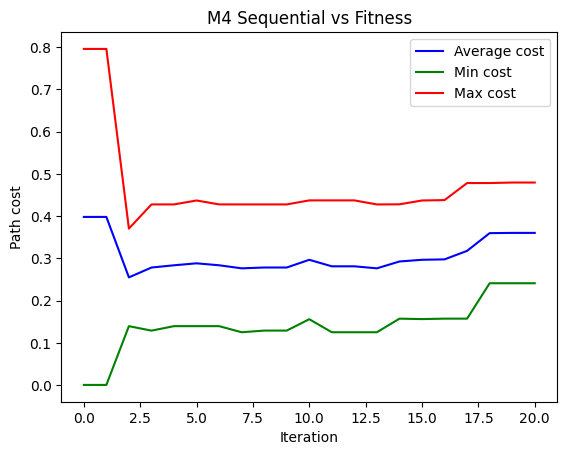

0.6891308426856995
0.4793938246642416


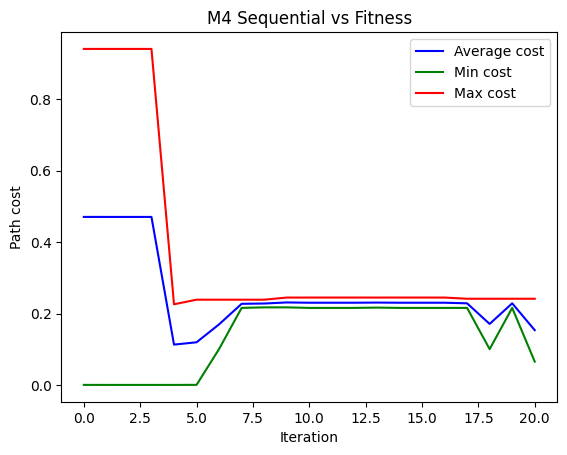

0.9399667978286743
0.24132628936747408


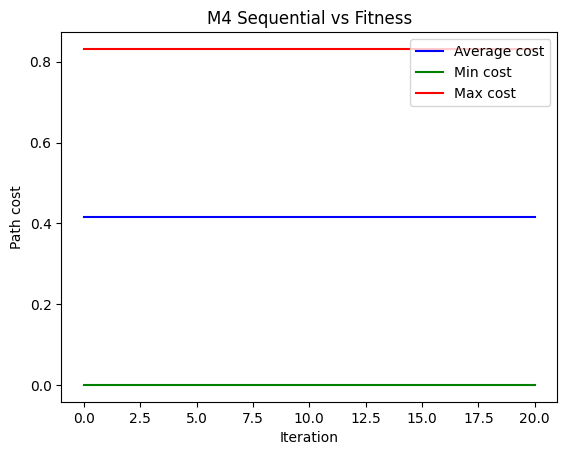

0.09099999815225601
0.8317762960706833


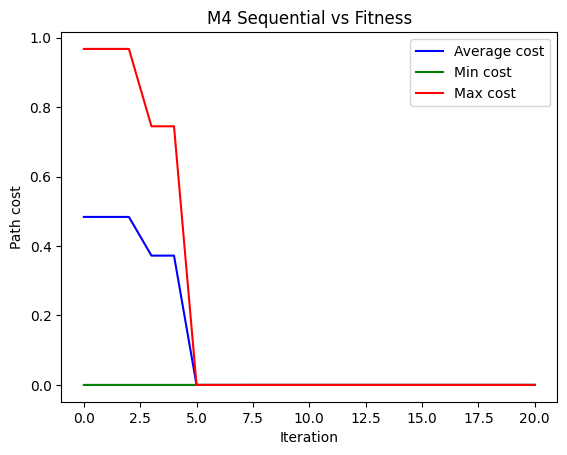

0.789138913154602
2.3623188228366457e-05


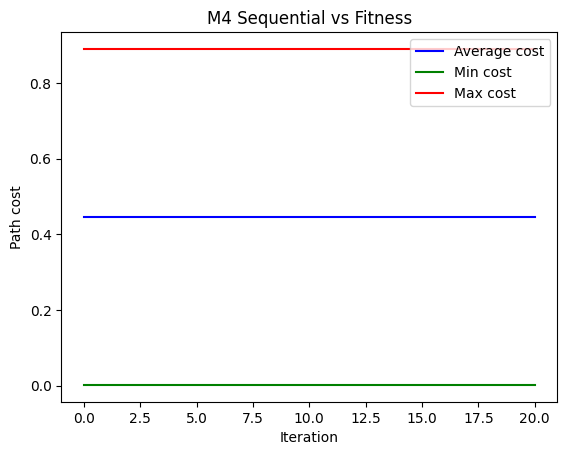

0.2549999952316284
0.8902162605655718


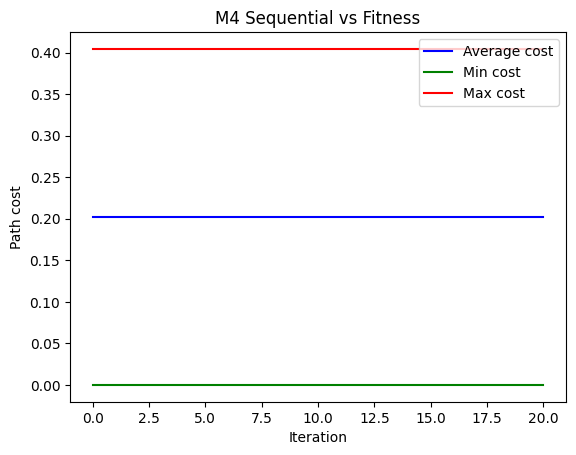

0.699999988079071
0.4044155648799235


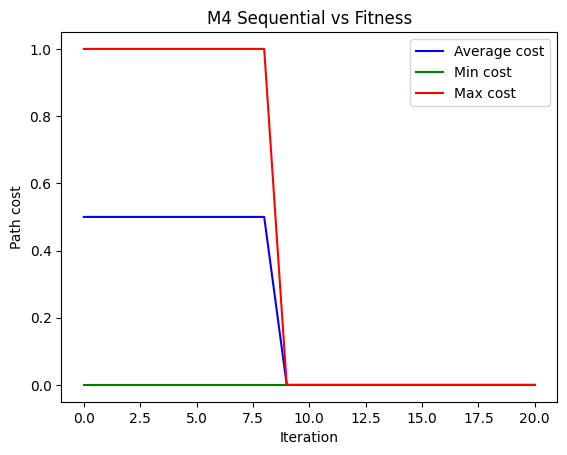

0.5682500004768372
7.809317762311391e-08


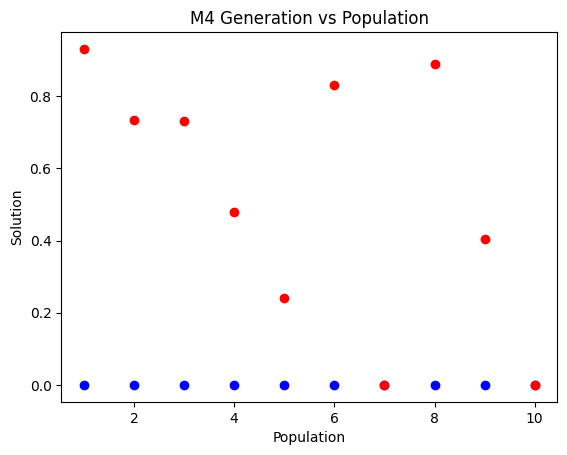

0.930708385724347
0.7328810668475813
0.7307452717066413
0.4793938246642416
0.24132628936747408
0.8317762960706833
2.3623188228366457e-05
0.8902162605655718
0.4044155648799235
7.809317762311391e-08


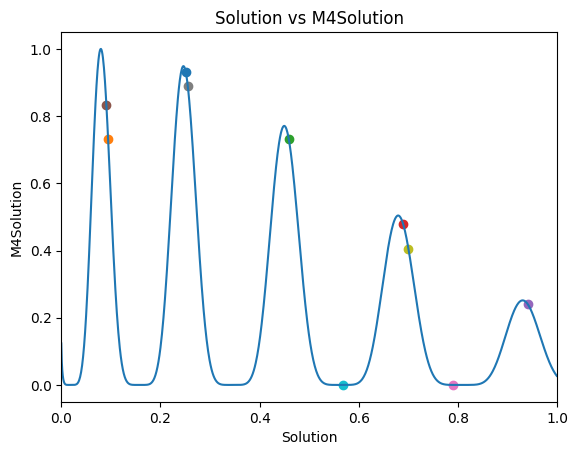

In [124]:
%run GeneticAlgorithmM4Sequential.py